In [250]:
import pandas as pd
import numpy as np
import csv
import copy
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import csv
import copy
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, scale
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import matplotlib.cm as cm

random_state = 32

def preprocess(filepath):
    df = pd.read_csv(filepath)
    attributes = df.columns
    nominalvalues = {}

    df = df.replace('N/A', np.NaN)
    # df = df.replace('?', np.NaN)
    for col in df.columns:
        # deal with the $ and ,
        if df[col].dtype == "object":
            df[col] = df[col].str.replace("$", "")
            df[col] = df[col].str.replace(",", "")
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                print("%r is string." %col)
        # deal with missing values
        if sum(pd.isnull(df[col])) != 0 or sum(df[col].isin(["?"])) > 0:
            print(filepath)
            print("%r column (type: %r): %r null" %(col, df[col].dtype, sum(pd.isnull(df[col]))))
            if df[col].dtype == "object":
                md = df[df[col] != np.NaN][col].mode()[0]
                df[col] = df[col].replace(np.NaN, md)

            else:
                mn = df[col].astype(float).mean()
                df[col] = df[col].replace(np.NaN, mn)
        if df[col].dtype == "object":
            nominalvalues[col] = df[col].unique().tolist()
            df[col] = df[col].astype(str)

    # generate arff file
    with open(filepath+".arff", "w") as f:
        f.write("@relation %r\n\n" %filepath)
        for attr in attributes:
            if attr in nominalvalues.keys():
                nv = "\",\"".join(nominalvalues[attr])
                nv = "\"" + nv + "\""
                f.write("@attribute " + attr.replace(" ", "_") + " {" + nv +"}\n")
            else:
                f.write("@attribute " + attr.replace(" ", "_") + " numeric\n")
        f.write("\n")
        f.write("@data\n")
        df.to_csv(filepath+".csv", header=False, index=False, quoting=csv.QUOTE_NONNUMERIC)
        with open(filepath+".csv") as nf:
            for line in nf:
                f.write(line)
    f.close()
    nf.close()

    return df, nominalvalues

def calsse(df, clusters, centroid):
    df = pd.DataFrame(df)
    total = 0
    count = 0
    for i in range(len(clusters)):
        for p in clusters[i]:
            count+=1
            total += distance(df.iloc[p, :], centroid[i])
    # print(count)
    return total

def distance(inst1, inst2):
    try:
        inst1 = np.array(inst1)
        inst2 = np.array(inst2)

        if len(inst1) != len(inst2):
            raise NameError("Not the same dimension.")

        total = 0
        for i in range(len(inst1)):
            total += (inst1[i] - inst2[i])**2
        return total
    except ValueError:
        return 100

class Clustering():
    def __init__(self, df, ndf, labelstr, labelindex, display):
        """
        :param k: int, number of cluster
        :param df: dataframe, raw dataframe
        :param ndf: dataframe, the dataframe used in model
        :param labelstr: str, label in the dataframe
        :param labelindex: int, index of label in the dataframe
        :param display: int, 0-display all label, 1-display count label
        """
        self.df = df
        self.ndf = ndf
        self.labelindex = labelindex

        self.display = display

        self.label = copy.deepcopy(df[labelstr])
        if display == 1:
            print("Labels distribution: ")
            print(self.label.groupby(self.label).count())

            labels = self.label.unique().tolist()

            for i in range(len(self.label)):
                self.label[i] = labels.index(self.label[i])


    def KMeans_fit_predict(self, k, preproc=0, seed=32):
        """
        :param k: number of clusters
        :param preproc: 0-no preprocess, 1-normalize, 2-standardiza
        :return:
        """
        if preproc == 1:
            ndf = pd.DataFrame(normalize(self.ndf, axis=0, copy=True))
        elif preproc == 2:
            ndf = pd.DataFrame(scale(self.ndf, axis=0, copy=True))
        else:
            ndf = self.ndf

        summary = "Summary: \n"
        summary += "KMeans, k=%r \n" % k

        kmeans = KMeans(n_clusters=k, random_state=seed)
        y_pred = kmeans.fit_predict(ndf)
        sse = kmeans.inertia_

        summary += "SSE: %r \n" %sse

        clusters = dict.fromkeys([i for i in range(k)], None)
        for i in range(len(clusters)):
            clusters[i] = []
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)

        categories = {}
        for i in range(k):
            categories[i] = [self.df.iloc[m, self.labelindex] for m in clusters.get(i)]
        for d in range(len(categories)):
            if self.display == 0:
                summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
            else:
                summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))

        cluster_center_ = {}
        for i in range(len(kmeans.cluster_centers_)):
            cluster_center_[i] = kmeans.cluster_centers_[i]

        return categories, y_pred, cluster_center_, sse, summary

    def AgglomerativeClustering_fit_predict(self, k, affinity="euclidean", linkage="complete", preproc=0, seed=32):
        if preproc == 1:
            ndf = pd.DataFrame(normalize(self.ndf, axis=0, copy=True))
        elif preproc == 2:
            ndf = pd.DataFrame(scale(self.ndf, axis=0, copy=True))
        else:
            ndf = self.ndf

        summary = "Summary: \n"
        summary += "AgglomerativeClustering, k=%r \n" % k

        ac = AgglomerativeClustering(n_clusters=k, affinity=affinity, linkage=linkage)
        y_pred = ac.fit_predict(ndf)

        clusters = dict.fromkeys([i for i in range(k)], None)
        for i in range(len(clusters)):
            clusters[i] = []
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)
        # calculate the center
        cluster_center_ = {}
        for i in range(k):
            cluster_center_[i] = ndf.iloc[clusters[i], :].mean().tolist()
        sse = 0
        for i in range(k):
            for iid in clusters[i]:
                sse += distance(ndf.iloc[iid, :], cluster_center_[i])

        summary += "SSE: %r \n" % sse

        categories = {}
        for i in range(k):
            categories[i] = [self.df.iloc[m, self.labelindex] for m in clusters.get(i)]
        for d in range(len(categories)):
            if self.display == 0:
                summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
            else:
                summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))

        return categories, y_pred, cluster_center_, sse, summary

    def DBSCAN_fit_predict(self, eps, min_s=1, preproc=0, seed=32):
        if preproc == 1:
            ndf = pd.DataFrame(normalize(self.ndf, axis=0, copy=True))
        elif preproc == 2:
            ndf = pd.DataFrame(scale(self.ndf, axis=0, copy=True))
        else:
            ndf = self.ndf

        summary = "Summary: \n"
        summary += "DBSCAN \n"

        dbs = DBSCAN(eps=eps, min_samples=min_s)
        y_pred = dbs.fit_predict(ndf)

        clusters = dict.fromkeys([i for i in set(y_pred)], None)
        for i in set(y_pred):
            clusters[i] = []
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)

        cluster_center_ = {}
        for i in set(y_pred):
            cluster_center_[i] = ndf.iloc[clusters[i], :].mean().tolist()
        sse = 0
        for i in set(y_pred):
            for iid in clusters[i]:
                sse += distance(ndf.iloc[iid, :], cluster_center_[i])

        summary += "SSE: %r \n" %sse
        
        # summary += "Std: %r \n" %

        categories = {}
        for i in set(y_pred):
            categories[i] = [self.df.iloc[m, self.labelindex] for m in clusters.get(i)]
        
        if -1 not in cluster_center_.keys():
            for d in range(len(categories)):
                if self.display == 0:
                    summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
                else:
                    summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))
        else:
            for d in range(-1, len(categories) - 1):
                if self.display == 0:
                    summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
                else:
                    summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))

        return categories, y_pred, cluster_center_, sse, summary

    def externalEval(self, y_pred, true_label):
        true_label = np.array(true_label)
        n_cluster = len(set(true_label))
        y_pred_modi = y_pred.copy()
        result = [[] for i in range(len(set(y_pred)))]
        for i in range(len(y_pred)):
            result[y_pred[i]].append(i)
        dict1 = dict.fromkeys([i for i in range(n_cluster)], None)
        for i in list(dict1.keys()):
            dict1[i] = []
        nummostnum = 0
        for i in range(len(result)):
            if len(true_label[result[i]]) > 0:
                mostnum = Counter(true_label[result[i]]).most_common(1)[0][0]
                nummostnum += Counter(true_label[result[i]]).most_common(1)[0][1]
                dict1[mostnum] += (result[i])
        for r in list(dict1.keys()):
            for i in dict1[r]:
                y_pred_modi[i] = r
        nmi = normalized_mutual_info_score(true_label, y_pred)
        purity = nummostnum / len(y_pred_modi)
        fowlkes_mallows = fowlkes_mallows_score(true_label, y_pred_modi)
        return nmi, purity, fowlkes_mallows

    def silhouette(self, range_n_clusters, cluster_labelss):
        X = self.ndf
        for n_cluster in range_n_clusters:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(12, 6)

            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X) + (n_cluster + 1) * 10])

            cluster_labels = cluster_labelss[n_cluster-2]

            # categories, cluster_labels, cluster_centers_, summary = self.kmeans_fit_predict(n_cluster, preproc)

            silhouette_avg = silhouette_score(X, cluster_labels)
            print("For n_clusters =", n_cluster,
                  "The average silhouette_score is :", silhouette_avg)

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_cluster):
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.spectral(float(i) / n_cluster)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # mds
            # mds
            similarities = euclidean_distances(X)
            mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=random_state,
                               dissimilarity="precomputed", n_jobs=1)
            pos = mds.fit(similarities).embedding_
            df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
            df_pos["pred"] = cluster_labels

            for i in range(n_cluster):
                color = cm.spectral(float(i) / n_cluster)
                ax2.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st MDS feature")
            ax2.set_ylabel("Feature space for the 2nd MDS feature")

            plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                          "with n_clusters = %d" % n_cluster),
                         fontsize=14, fontweight='bold')
            # end mds
            plt.show()

class visualization():
    def MDSplot(self, ndf, y_pred, n_clusters, show=False):
        fig, ax = plt.subplots()
        similarities = euclidean_distances(ndf)
        mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                           dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
        df_pos["pred"] = y_pred

        for i in range(n_clusters):
            color = cm.spectral(float(i) / n_clusters)
            ax.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)
        ax.set_title("The MDS visualization of the clustered data.")
        ax.set_xlabel("1st MDS feature")
        ax.set_ylabel("2nd MDS feature")
        if show:
            plt.plot()
        return ax

    def Comparingplot(self, range_n_clusters, sses, nmis, purities, fms):

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
        fig.set_size_inches(12, 6)

        ax1.set_title("SSE")
        #ax1.set_xlabel("num of clusters")
        ax1.set_ylabel("SSE")
        ax1.plot(range_n_clusters, sses)

        ax2.set_title("NMI")
        #ax2.set_xlabel("num of clusters")
        ax2.set_ylabel("NMI")
        ax2.plot(range_n_clusters, nmis)

        ax3.set_title("Purity")
        #ax3.set_xlabel("num of clusters")
        ax3.set_ylabel("Purity")
        ax3.plot(range_n_clusters, purities)

        ax4.set_title("fowlkes_mallows score")
        #ax4.set_xlabel("num of clusters")
        ax4.set_ylabel("fowlkes_mallows score")
        ax4.plot(range_n_clusters, fms)
        plt.show()

    def visualizeData(self, kcentroid, summary):
        print(summary)
        length = len(kcentroid[0])
        ind = np.arange(length)  # the x locations for the groups
        width = 0.15  # the width of the bars
        fig, ax = plt.subplots()
        fig.set_size_inches(9, 4)
        if -1 not in kcentroid.keys():
            for k in range(len(kcentroid)):
                color = cm.spectral(float(k) / len(kcentroid))
                ax.bar(ind + k * width, kcentroid[k], width, color=color)
        else:
            for k in range(-1, len(kcentroid) - 1):
                color = cm.spectral(float(k+1) / len(kcentroid))
                ax.bar(ind + k * width, kcentroid[k], width, color=color)
        ax.set_xticks(ind + width / 2)
        if length == 7:
            ax.set_xticklabels(('Start Median', 'Mid Median', 'Percent', '10th', '25th', '75th', '90th'))
        else:
            ax.set_xticklabels(('Start Median', 'Mid Median', '10th', '25th', '75th', '90th'))


In [2]:
dtpb, dtpb_nom = preprocess("college-salaries/degrees-that-pay-back.csv")
sbct, sbct_nom = preprocess("college-salaries/salaries-by-college-type.csv")
sbr, sbr_nom = preprocess("college-salaries/salaries-by-region.csv")

'Undergraduate Major' is string.
'Major' is string.
'School Name' is string.
'School Type' is string.
college-salaries/salaries-by-college-type.csv
'Mid-Career 10th Percentile Salary' column (type: dtype('float64')): 38 null
college-salaries/salaries-by-college-type.csv
'Mid-Career 90th Percentile Salary' column (type: dtype('float64')): 38 null
'School Name' is string.
'Region' is string.
college-salaries/salaries-by-region.csv
'Mid-Career 10th Percentile Salary' column (type: dtype('float64')): 47 null
college-salaries/salaries-by-region.csv
'Mid-Career 90th Percentile Salary' column (type: dtype('float64')): 47 null


# degrees-that-pay-back

In [227]:
dtpb, dtpb_nom = preprocess("college-salaries/degrees-that-pay-back.csv")

'Undergraduate Major' is string.
'Major' is string.


In [228]:
dtpb["Major"].unique()

array(['Business', 'Science_Math_Technology', 'Social_Sciences',
       'Arts_and_Humanities', 'Public_Social_Services', 'Health_Medicine'], dtype=object)

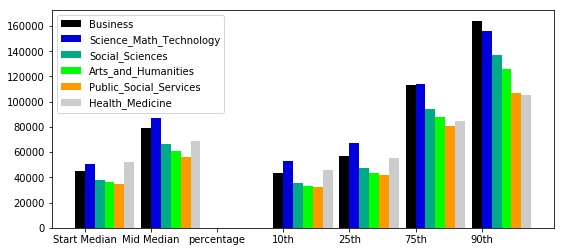

In [230]:
maj = ["Business", "Science_Math_Technology", "Social_Sciences", "Arts_and_Humanities", "Public_Social_Services", "Health_Medicine"]

length = 7
ind = np.arange(length)  # the x locations for the groups
width = 0.15  # the width of the bars
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
k = 0
for st in maj:
    color = cm.spectral(float(k) / len(schooltype))
    ax.bar(ind + k * width, dtpb[dtpb["Major"] == st].describe().loc["mean"].tolist(), width, color=color, label=st)
    k += 1
ax.set_xticks(ind + width / 2)
ax.legend(loc="best")
ax.set_xticklabels(('Start Median', 'Mid Median', "percentage", '10th', '25th', '75th', '90th'))

In [241]:
dtpb = dtpb.drop("Major", axis=1)
dtpb.head()

,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,Percent change from Starting to Mid-Career Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Accounting,46000.0,77100.0,67.6,42200.0,56100.0,108000.0,152000.0
1,Aerospace Engineering,57700.0,101000.0,75.0,64300.0,82100.0,127000.0,161000.0
2,Agriculture,42600.0,71900.0,68.8,36300.0,52100.0,96300.0,150000.0
3,Anthropology,36800.0,61500.0,67.1,33800.0,45500.0,89300.0,138000.0
4,Architecture,41600.0,76800.0,84.6,50600.0,62200.0,97000.0,136000.0


In [290]:
clustering = Clustering(dtpb, dtpb.iloc[:, 1:], "Undergraduate Major", 0, 0)

In [291]:
categories, y_pred, cluster_centers_, sse, summary = \
clustering.KMeans_fit_predict(5)
print(summary)

Summary: 
KMeans, k=5 
SSE: 12756201735.466633 
Cluster 0: 'Aerospace Engineering, Civil Engineering, Computer Engineering, Computer Science, Construction, Electrical Engineering, Industrial Engineering, Mechanical Engineering, Physician Assistant'
Cluster 1: 'Criminal Justice, Education, Forestry, Graphic Design, Health Care Administration, Interior Design, Nursing, Nutrition, Religion, Sociology, Spanish'
Cluster 2: 'Accounting, Agriculture, Business Management, Chemistry, Geology, History, International Relations, Management Information Systems (MIS), Marketing, Philosophy, Political Science'
Cluster 3: 'Anthropology, Architecture, Art History, Biology, Communications, Drama, English, Film, Geography, Hospitality & Tourism, Information Technology (IT), Journalism, Music, Psychology'
Cluster 4: 'Chemical Engineering, Economics, Finance, Math, Physics'



For n_clusters = 2 The average silhouette_score is : 0.498912030272


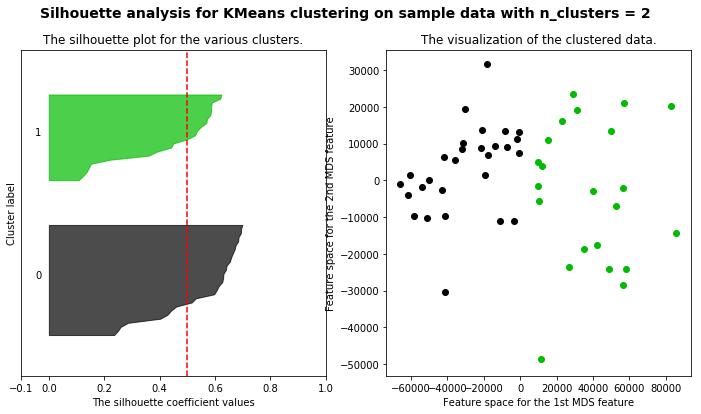

For n_clusters = 3 The average silhouette_score is : 0.426487034384


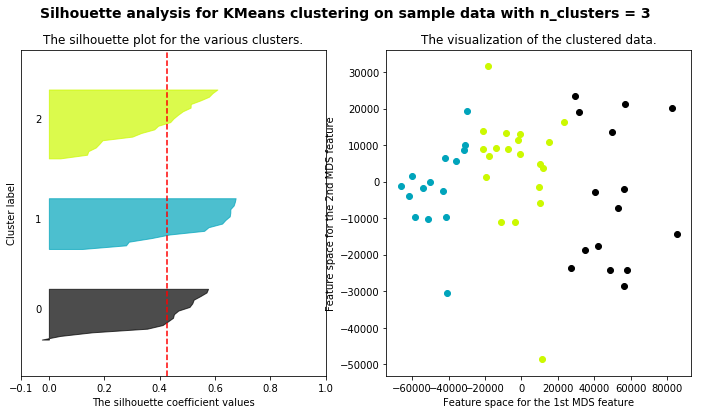

For n_clusters = 4 The average silhouette_score is : 0.412701945984


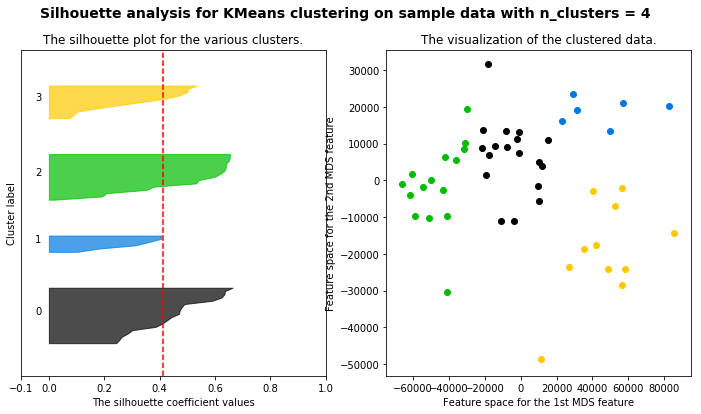

For n_clusters = 5 The average silhouette_score is : 0.377159882763


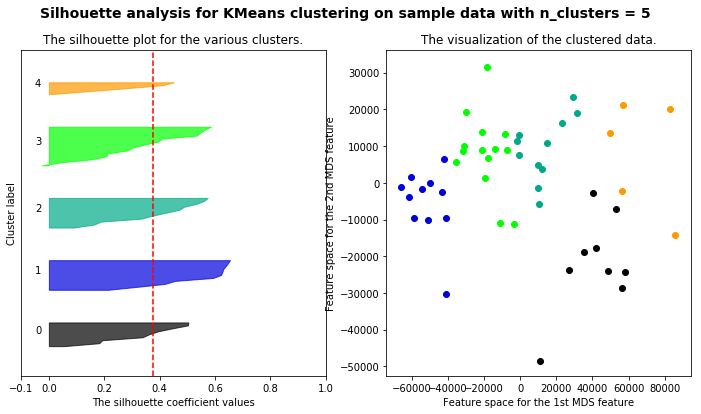

For n_clusters = 6 The average silhouette_score is : 0.360383420052


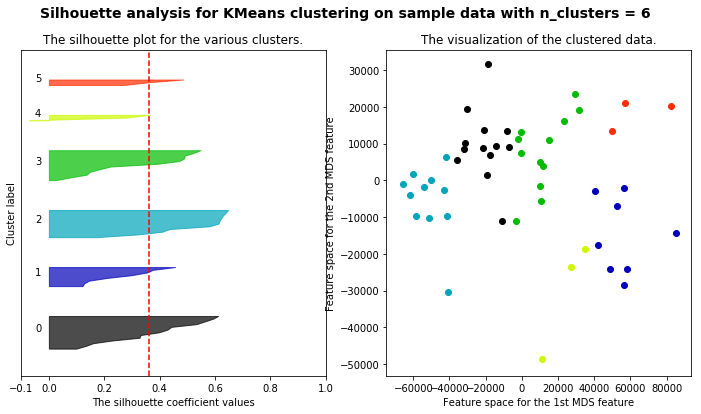

For n_clusters = 7 The average silhouette_score is : 0.383038804513


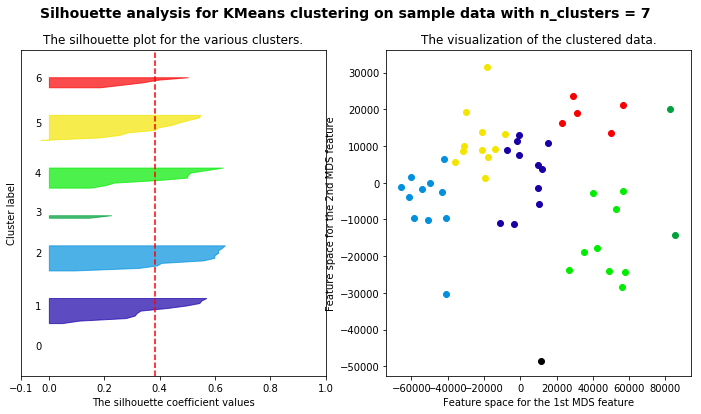

For n_clusters = 8 The average silhouette_score is : 0.353631933026


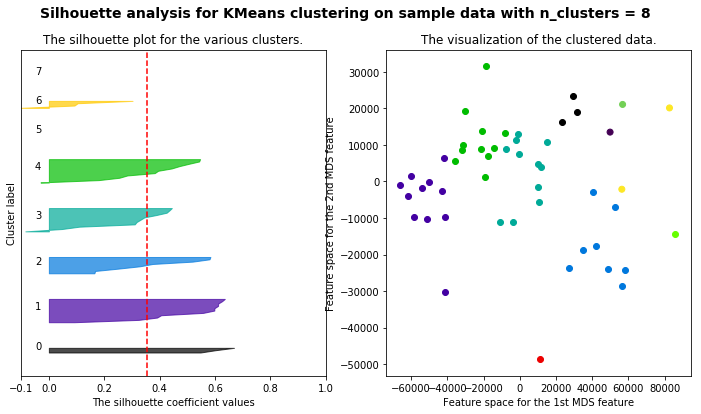

In [115]:
range_n_clusters = [2,3,4,5,6,7,8]
cluster_labelss = []
sses = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = clustering.KMeans_fit_predict(cluster)
    cluster_labelss.append(y_pred)
    sses.append(sse)
clustering.silhouette(range_n_clusters, cluster_labelss)

Summary: 
KMeans, k=5 
SSE: 12756201735.466633 
Cluster 0: 'Aerospace Engineering, Civil Engineering, Computer Engineering, Computer Science, Construction, Electrical Engineering, Industrial Engineering, Mechanical Engineering, Physician Assistant'
Cluster 1: 'Criminal Justice, Education, Forestry, Graphic Design, Health Care Administration, Interior Design, Nursing, Nutrition, Religion, Sociology, Spanish'
Cluster 2: 'Accounting, Agriculture, Business Management, Chemistry, Geology, History, International Relations, Management Information Systems (MIS), Marketing, Philosophy, Political Science'
Cluster 3: 'Anthropology, Architecture, Art History, Biology, Communications, Drama, English, Film, Geography, Hospitality & Tourism, Information Technology (IT), Journalism, Music, Psychology'
Cluster 4: 'Chemical Engineering, Economics, Finance, Math, Physics'



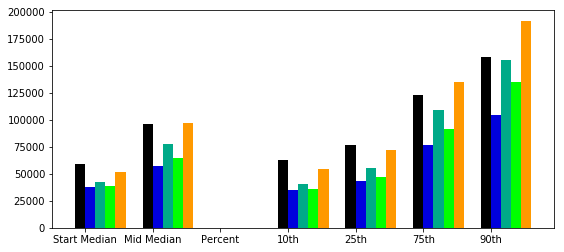

In [244]:
categories, y_pred, cluster_centers_, sse, summary = \
clustering.KMeans_fit_predict(5, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

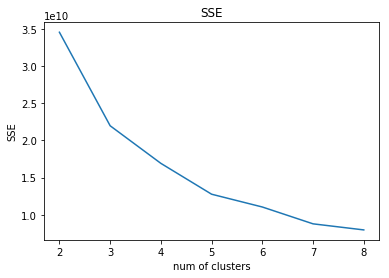

In [50]:
plt.title("SSE")
plt.xlabel("num of clusters")
plt.ylabel("SSE")
plt.plot(range_n_clusters, sses)

Summary: 
AgglomerativeClustering, k=5 
SSE: 141863334032.81659 
Cluster 0: Counter({'Liberal Arts': 16, 'Engineering': 13, 'State': 7, 'Party': 1, 'Ivy League': 1})
Cluster 1: Counter({'State': 122, 'Liberal Arts': 28, 'Party': 19, 'Engineering': 5})
Cluster 2: Counter({'Ivy League': 5, 'Liberal Arts': 2})
Cluster 3: Counter({'State': 46, 'Engineering': 1, 'Liberal Arts': 1})
Cluster 4: Counter({'Ivy League': 2})



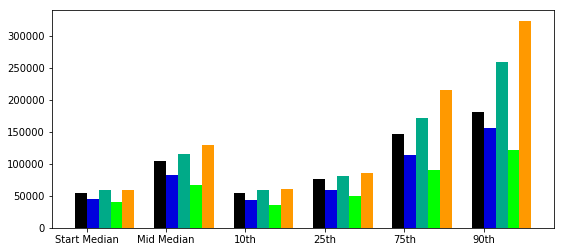

In [238]:
categories, y_pred, cluster_centers_, sse, summary = \
clustering.AgglomerativeClustering_fit_predict(5, affinity="euclidean", linkage="complete", preproc=0)
visualization().visualizeData(cluster_centers_, summary)

For n_clusters = 2 The average silhouette_score is : 0.491014349091


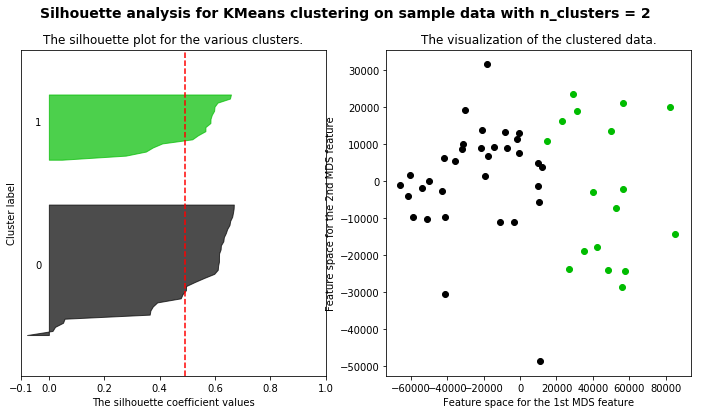

For n_clusters = 3 The average silhouette_score is : 0.393361709756


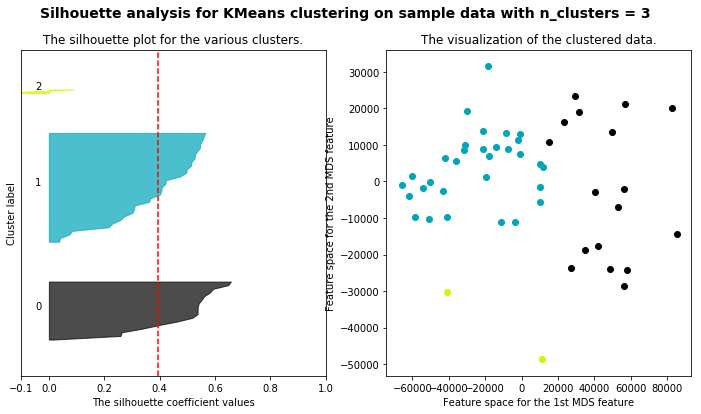

For n_clusters = 4 The average silhouette_score is : 0.323727354807


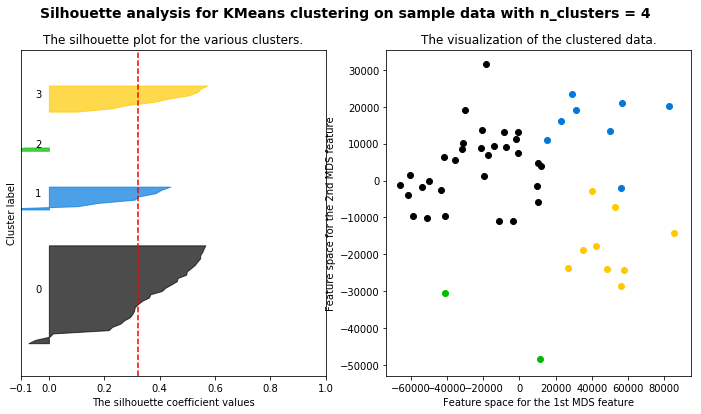

For n_clusters = 5 The average silhouette_score is : 0.351649719662


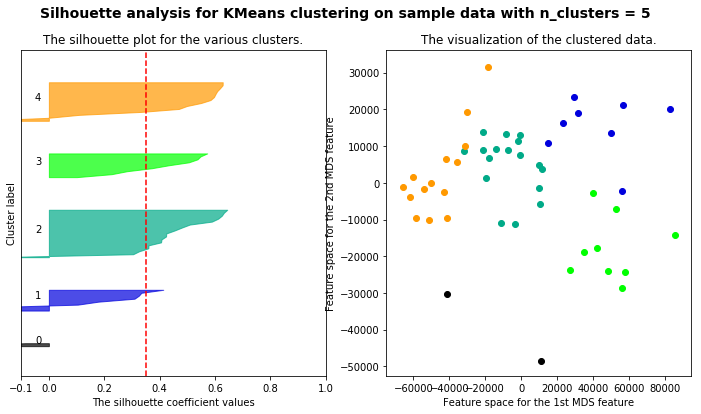

For n_clusters = 6 The average silhouette_score is : 0.307171759558


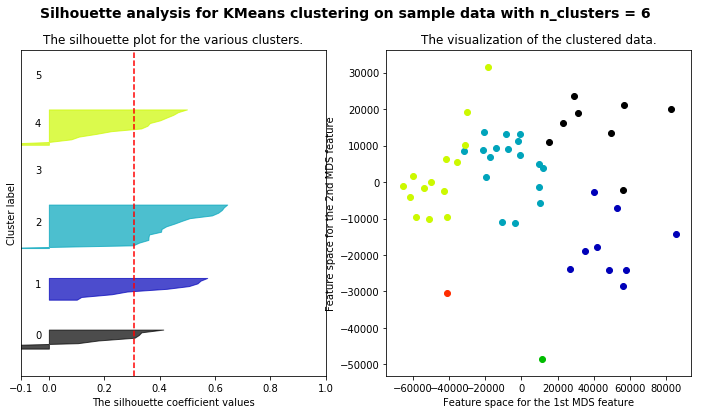

For n_clusters = 7 The average silhouette_score is : 0.280448275216


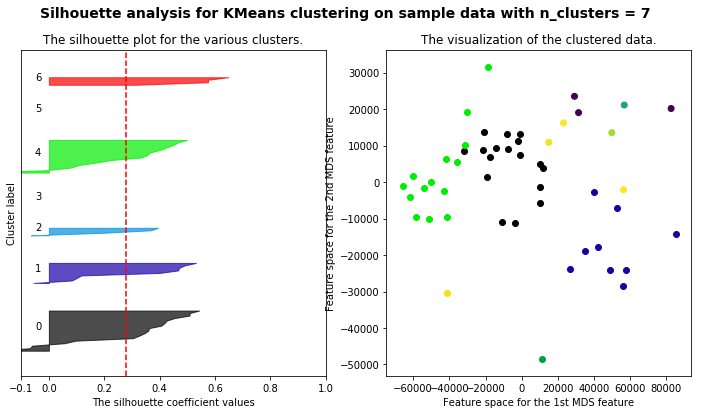

For n_clusters = 8 The average silhouette_score is : 0.272049639269


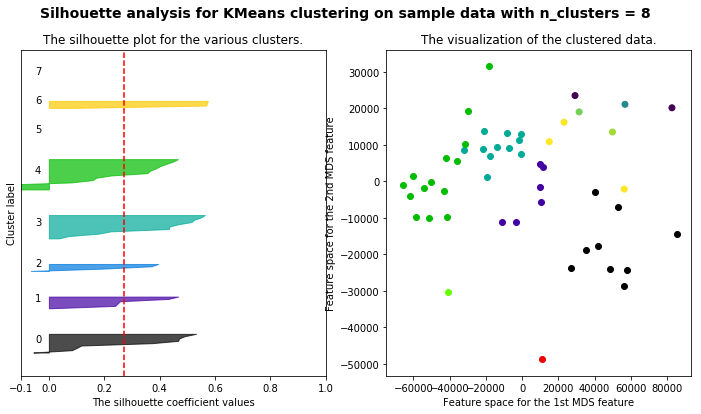

In [122]:
range_n_clusters = [2,3,4,5,6,7,8]
cluster_labelss = []
sses = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = \
    clustering.AgglomerativeClustering_fit_predict(cluster, affinity="euclidean", linkage="complete", preproc=1)
    cluster_labelss.append(y_pred)
    sses.append(sse)
clustering.silhouette(range_n_clusters, cluster_labelss)

array([  8009.36951389,   8849.29599968,   9128.5272087 ,   9393.62164929,
        10111.87421253,  10297.09789212,  10807.88545877,  10810.18538971,
        10810.18538971,  10903.67560092,  11038.5844183 ,  11038.5844183 ,
        11086.48027509,  11436.78285009,  11714.09952536,  11800.43190777,
        11818.22639993,  11950.31472765,  12087.61366069,  12163.47308296,
        12600.40622996,  12899.22881571,  12996.9313686 ,  13341.30694085,
        13792.39791516,  13877.69045663,  13912.94454851,  14792.90915574,
        15106.95262586,  16477.58872681,  16640.61412448,  17941.30933934,
        18883.06433845,  19728.65998997,  19993.24956304,  19993.24956304,
        20336.42226548,  20585.92445362,  21034.51891439,  21530.47709643,
        21679.9457474 ,  22444.17529984,  24611.78579461,  25298.41903677,
        25869.48148398,  26622.17414581,  28899.16827886,  34461.283015  ,
        35168.87845184,  43533.90443333])

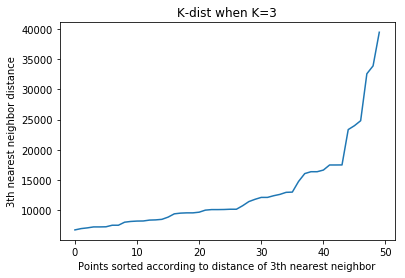

In [153]:
from sklearn.neighbors import NearestNeighbors
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(dtpb.iloc[:, 1:])
distances, indices = nbrs.kneighbors(dtpb.iloc[:, 1:])
dist = distances[:, k-1]
dist.sort()
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.plot(np.arange(0, len(dist)), dist)

Summary: 
DBSCAN 
SSE: 47089790856.863754 
Cluster -1: 'Chemical Engineering, Economics, Nursing, Physician Assistant'
Cluster 0: 'Accounting, Agriculture, Anthropology, Architecture, Art History, Biology, Business Management, Chemistry, Communications, Criminal Justice, Drama, Education, English, Film, Forestry, Geography, Geology, Graphic Design, Health Care Administration, History, Hospitality & Tourism, Information Technology (IT), Interior Design, International Relations, Journalism, Management Information Systems (MIS), Marketing, Music, Nutrition, Philosophy, Political Science, Psychology, Religion, Sociology, Spanish'
Cluster 1: 'Aerospace Engineering, Civil Engineering, Computer Engineering, Computer Science, Construction, Electrical Engineering, Finance, Industrial Engineering, Math, Mechanical Engineering, Physics'



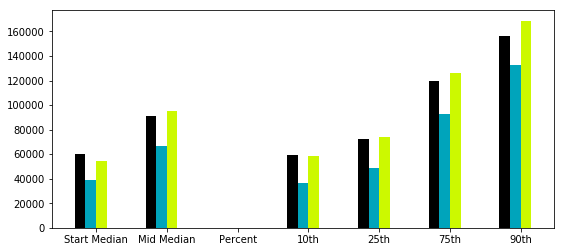

In [90]:
categories, y_pred, cluster_centers_, sse, summary = \
clustering.DBSCAN_fit_predict(eps=20000, min_s=2, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

# salaries-by-college-type

In [16]:
sbct.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),Engineering,72200.0,126000.0,76800.000000,99200.0,168000.0,220000.000000
1,California Institute of Technology (CIT),Engineering,75500.0,123000.0,44250.649351,104000.0,161000.0,157705.627706
2,Harvey Mudd College,Engineering,71800.0,122000.0,44250.649351,96000.0,180000.0,157705.627706
3,Polytechnic University of New York Brooklyn,Engineering,62400.0,114000.0,66800.000000,94300.0,143000.0,190000.000000
4,Cooper Union,Engineering,62200.0,114000.0,44250.649351,80200.0,142000.0,157705.627706


In [199]:
sbctcluster1 = Clustering(sbct, sbct.iloc[:, 2:], "School Type", 1, 1)
sbctcluster2 = Clustering(sbct, sbct.iloc[:, 2:], "School Name", 0, 0)

Labels distribution: 
School Type
Engineering      19
Ivy League        8
Liberal Arts     47
Party            20
State           175
Name: School Type, dtype: int64


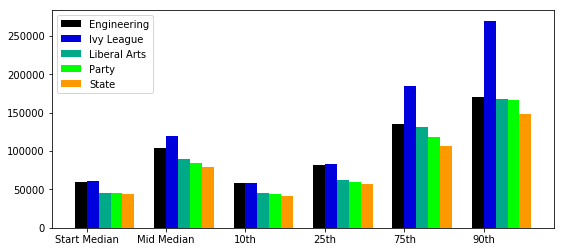

In [166]:
schooltype = ["Engineering", "Ivy League", "Liberal Arts", "Party", "State"]

length = 6
ind = np.arange(length)  # the x locations for the groups
width = 0.15  # the width of the bars
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
k = 0
for st in schooltype:
    color = cm.spectral(float(k) / len(schooltype))
    ax.bar(ind + k * width, sbct[sbct["School Type"] == st].describe().loc["mean"].tolist(), width, color=color, label=st)
    k += 1
ax.set_xticks(ind + width / 2)
ax.legend(loc="best")
ax.set_xticklabels(('Start Median', 'Mid Median', '10th', '25th', '75th', '90th'))

For n_clusters = 2 The average silhouette_score is : 0.497488112163


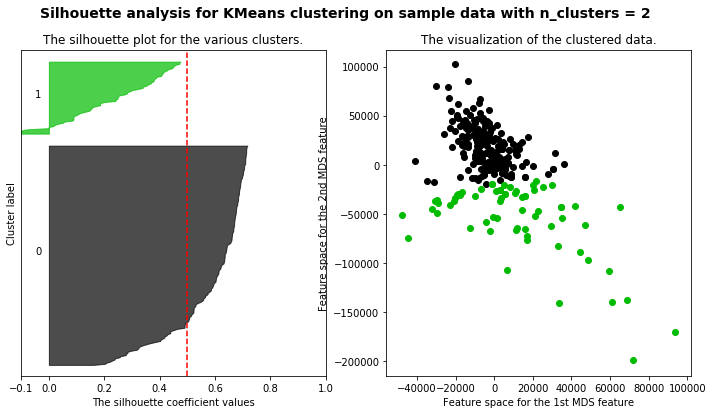

For n_clusters = 3 The average silhouette_score is : 0.408348086949


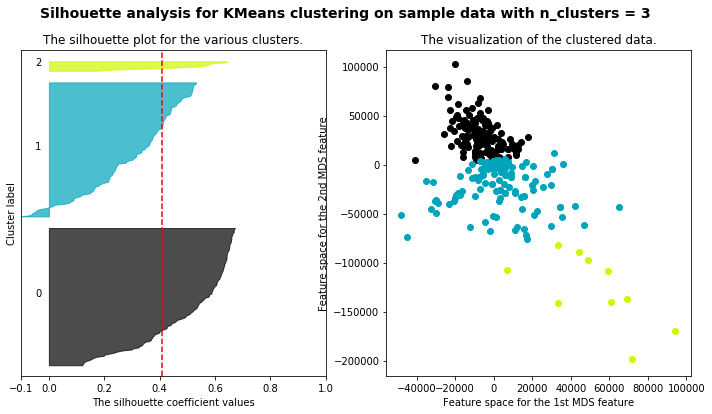

For n_clusters = 4 The average silhouette_score is : 0.391900437304


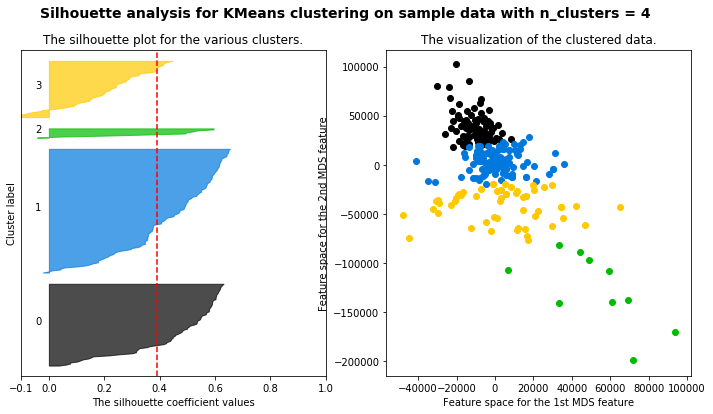

For n_clusters = 5 The average silhouette_score is : 0.379425610402


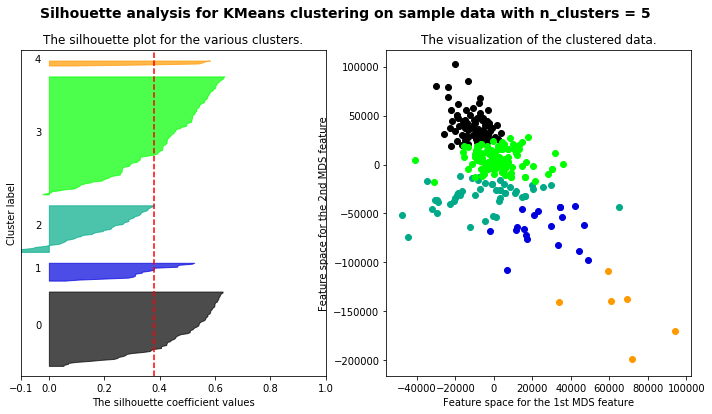

For n_clusters = 6 The average silhouette_score is : 0.33679790136


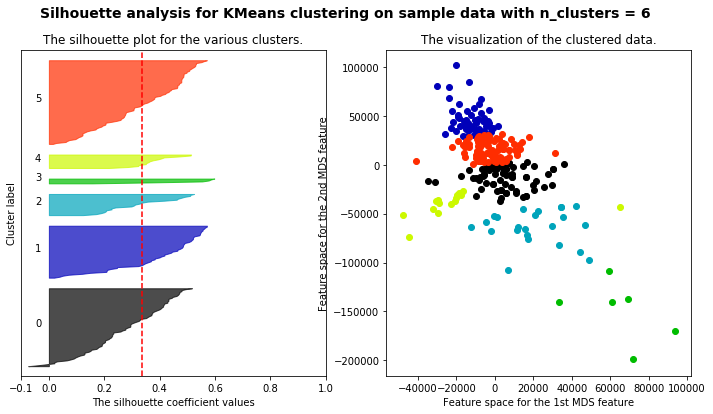

For n_clusters = 7 The average silhouette_score is : 0.305328004264


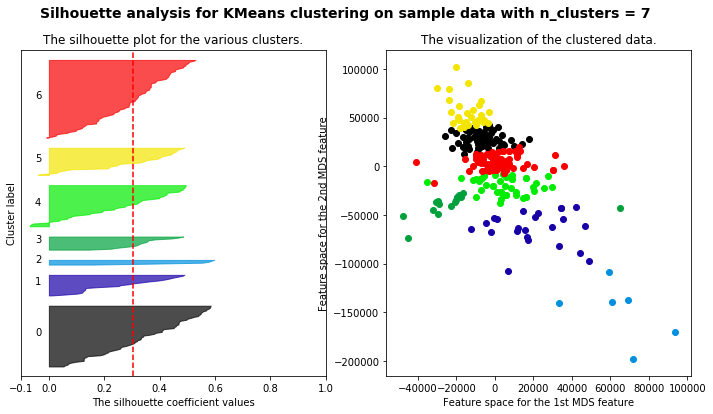

For n_clusters = 8 The average silhouette_score is : 0.310635061202


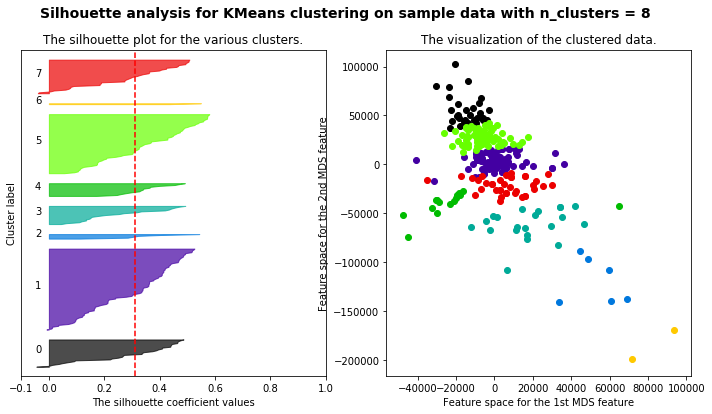

In [171]:
range_n_clusters = [2,3,4,5,6,7,8]
cluster_labelss = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = sbctcluster1.KMeans_fit_predict(cluster)
    cluster_labelss.append(y_pred)
sbctcluster1.silhouette(range_n_clusters, cluster_labelss)

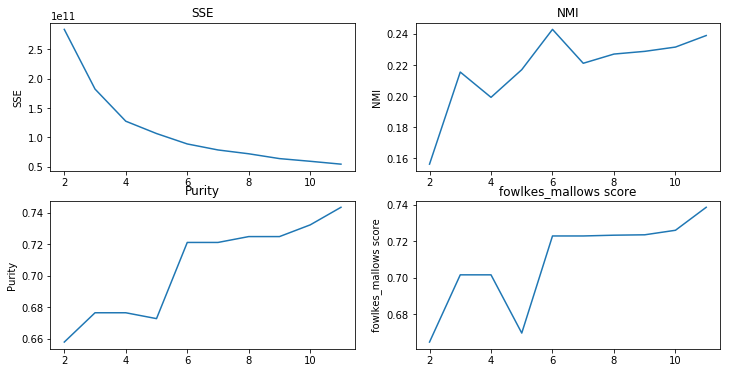

In [251]:
range_n_clusters = [2,3,4,5,6,7,8,9,10,11]
sses = []
nmis = []
purities = []
fms = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = \
    sbctcluster1.KMeans_fit_predict(cluster)
    sses.append(sse)
    nmi, purity, fowlkes_mallows = sbctcluster1.externalEval(y_pred, sbctcluster1.label)
    nmis.append(nmi)
    purities.append(purity)
    fms.append(fowlkes_mallows)
visualization().Comparingplot(range_n_clusters, sses, nmis, purities, fms)

Summary: 
KMeans, k=3 
SSE: 182348168507.59668 
Cluster 0: 'Embry-Riddle Aeronautical University (ERAU), Tennessee Technological University, University of New Hampshire (UNH), West Virginia University (WVU), University of Tennessee, Ohio University, Florida State University (FSU), University of Puget Sound, Reed College, Gustavus Adolphus College, Ursinus College, Moravian College, Lewis & Clark College, Fort Lewis College, Thomas Aquinas College, Evergreen State College, Clemson University, University of Washington (UW), Auburn University, Iowa State University, University of Colorado - Denver, University of Minnesota, Oregon State University (OSU), University of Utah, University of Nevada Reno (UNR), University of Alabama at Huntsville (UAH), California State University Sacramento (CSUS), University of Idaho, University of Illinois at Chicago, State University of New York (SUNY) at Buffalo, University of New Mexico (UNM), University of California Riverside (UCR), University of Missou

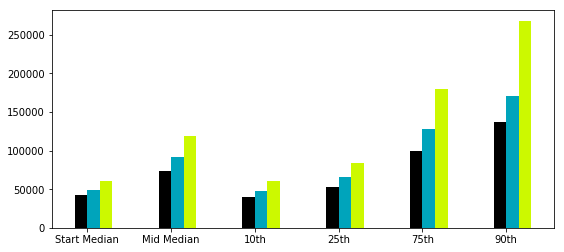

In [289]:
num_cluster = 3
categories, y_pred, cluster_centers_, sse, summary = \
    sbctcluster2.KMeans_fit_predict(num_cluster, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

Summary: 
KMeans, k=3 
SSE: 182348168507.59668 
Cluster 0: Counter({'State': 115, 'Liberal Arts': 9, 'Party': 5, 'Engineering': 2})
Cluster 1: Counter({'State': 60, 'Liberal Arts': 36, 'Engineering': 16, 'Party': 15, 'Ivy League': 1})
Cluster 2: Counter({'Ivy League': 7, 'Liberal Arts': 2, 'Engineering': 1})



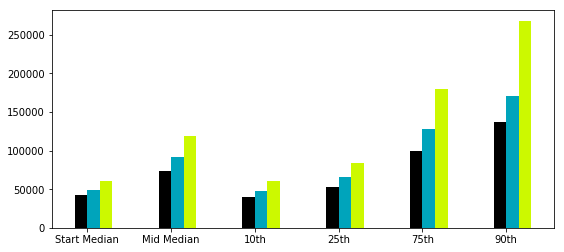

In [135]:
num_cluster = 3
categories, y_pred, cluster_centers_, sse, summary = \
    clustering.KMeans_fit_predict(num_cluster, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

Summary: 
AgglomerativeClustering, k=4 
SSE: 300994033090.43793 
Cluster 0: Counter({'State': 170, 'Liberal Arts': 45, 'Party': 20, 'Engineering': 18, 'Ivy League': 1})
Cluster 1: Counter({'Ivy League': 5, 'Liberal Arts': 2, 'Engineering': 1})
Cluster 2: Counter({'Ivy League': 2})
Cluster 3: Counter({'State': 5})



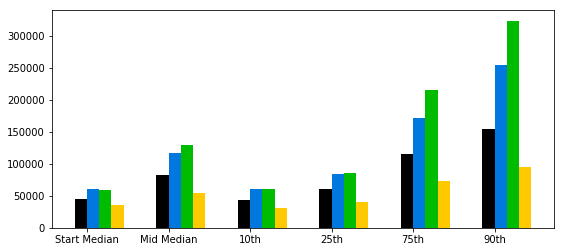

In [257]:
num_cluster = 4
categories, y_pred, cluster_centers_, sse, summary = \
    sbctcluster1.AgglomerativeClustering_fit_predict(num_cluster, affinity="euclidean", linkage="average")
visualization().visualizeData(cluster_centers_, summary)

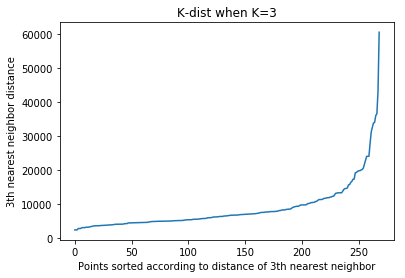

In [197]:
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(sbct.iloc[:, 2:])
distances, indices = nbrs.kneighbors(sbct.iloc[:, 2:])
dist = distances[:, k-1]
dist.sort()
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.plot(np.arange(0, len(dist)), dist)

In [208]:
import time

In [210]:
time.time()

1510788120.7573178

0.048742055892944336
Summary: 
DBSCAN 
SSE: 338107266544.31598 
Cluster -1: 'Massachusetts Institute of Technology (MIT), California Institute of Technology (CIT), Harvey Mudd College, South Dakota School of Mines & Technology, Bucknell University, Colgate University, Union College, University of Richmond, Franklin and Marshall College, Colorado College (CC), Skidmore College, Dartmouth College, Princeton University, Yale University, Harvard University, University of Pennsylvania, Brown University, Columbia University, Black Hills State University'
Cluster 0: 'Polytechnic University of New York Brooklyn, Worcester Polytechnic Institute (WPI), Carnegie Mellon University (CMU), Rensselaer Polytechnic Institute (RPI), Georgia Institute of Technology, Colorado School of Mines, Stevens Institute of Technology, Lafayette College, Cornell University, University of California Berkeley'
Cluster 1: 'Cooper Union, Illinois Institute of Technology (IIT), Wentworth Institute of Technology, Virginia

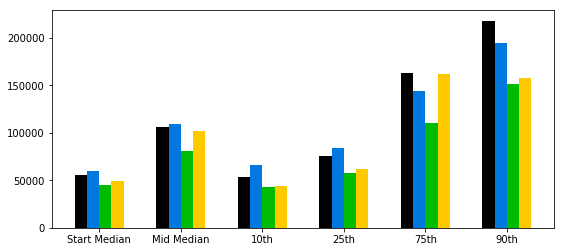

In [260]:
starttime = time.time()
categories, y_pred, cluster_centers_, sse, summary = \
    sbctcluster2.DBSCAN_fit_predict(preproc=0, eps=17000, min_s=3)
endtime = time.time()
print(endtime - starttime)
visualization().visualizeData(cluster_centers_, summary)

# salaries-by-region

In [212]:
sbr.head()

,School Name,Region,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Stanford University,California,70400.0,129000.0,68400.000000,93100.0,184000.0,257000.000000
1,California Institute of Technology (CIT),California,75500.0,123000.0,45253.113553,104000.0,161000.0,160442.124542
2,Harvey Mudd College,California,71800.0,122000.0,45253.113553,96000.0,180000.0,160442.124542
3,University of California Berkeley,California,59900.0,112000.0,59500.000000,81000.0,149000.0,201000.000000
4,Occidental College,California,51900.0,105000.0,45253.113553,54800.0,157000.0,160442.124542


In [220]:
sbrcluster1 = Clustering(sbr, sbr.iloc[:, 2:], "Region", 1, 1)
sbrcluster2 = Clustering(sbr, sbr.iloc[:, 2:], "School Name", 0, 0)

Labels distribution: 
Region
California       28
Midwestern       71
Northeastern    100
Southern         79
Western          42
Name: Region, dtype: int64


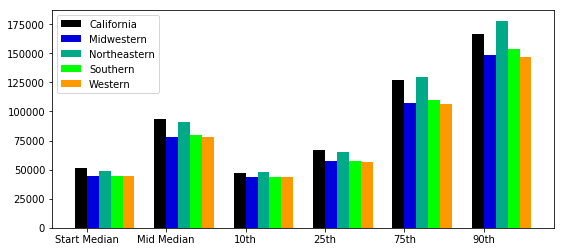

In [214]:
region = ["California", "Midwestern", "Northeastern", "Southern", "Western"]

length = 6
ind = np.arange(length)  # the x locations for the groups
width = 0.15  # the width of the bars
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
k = 0
for re in region:
    color = cm.spectral(float(k) / len(region))
    ax.bar(ind + k * width, sbr[sbr["Region"] == re].describe().loc["mean"].tolist(), width, color=color, label=re)
    k += 1
ax.set_xticks(ind + width / 2)
ax.legend(loc="best")
ax.set_xticklabels(('Start Median', 'Mid Median', '10th', '25th', '75th', '90th'))

For n_clusters = 2 The average silhouette_score is : 0.496311558165


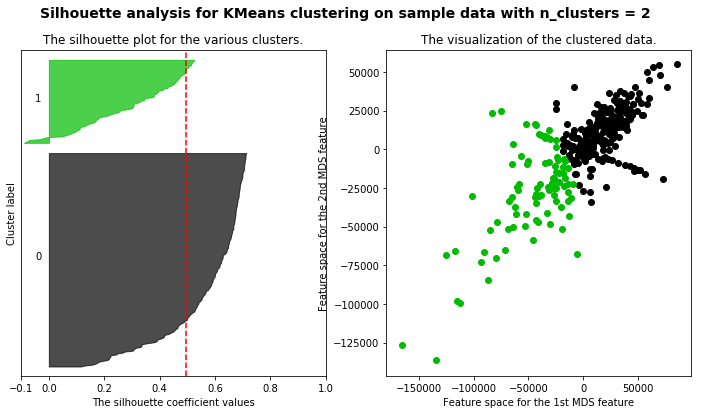

For n_clusters = 3 The average silhouette_score is : 0.408018147584


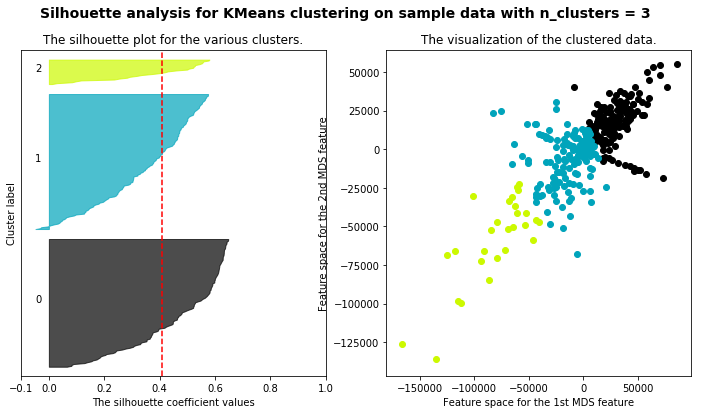

For n_clusters = 4 The average silhouette_score is : 0.371360929626


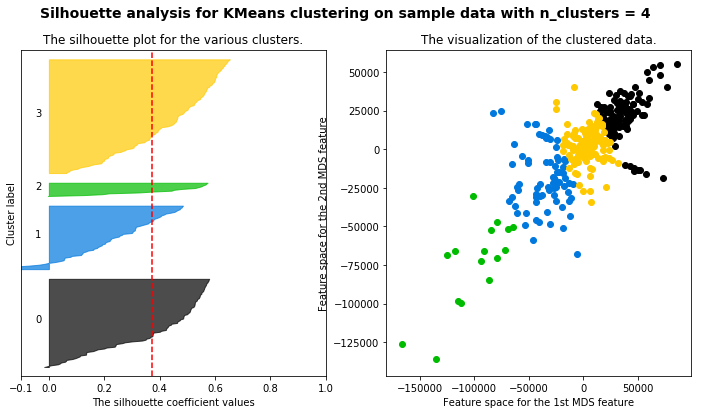

For n_clusters = 5 The average silhouette_score is : 0.335537138985


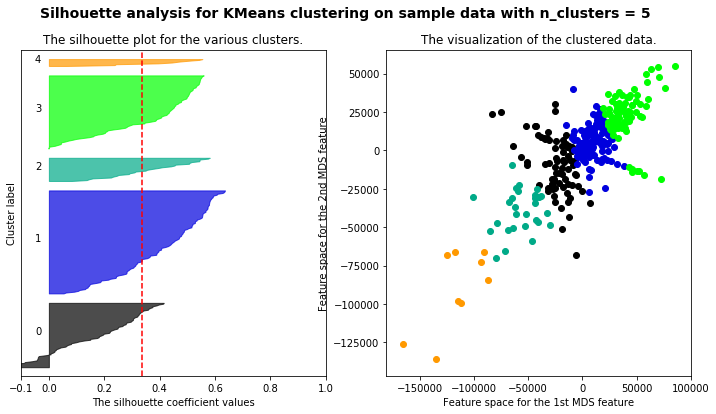

For n_clusters = 6 The average silhouette_score is : 0.320061455597


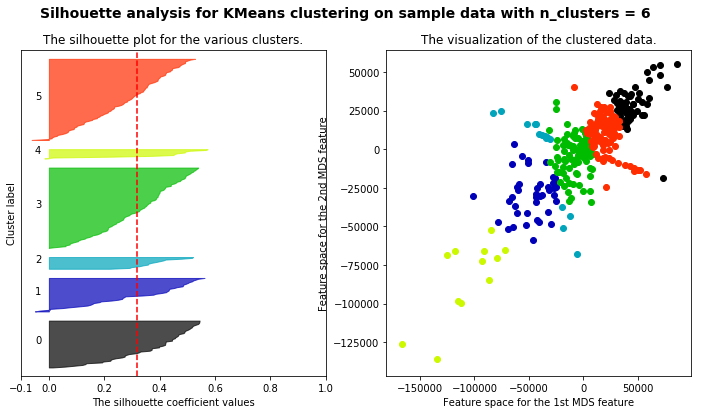

For n_clusters = 7 The average silhouette_score is : 0.313183812801


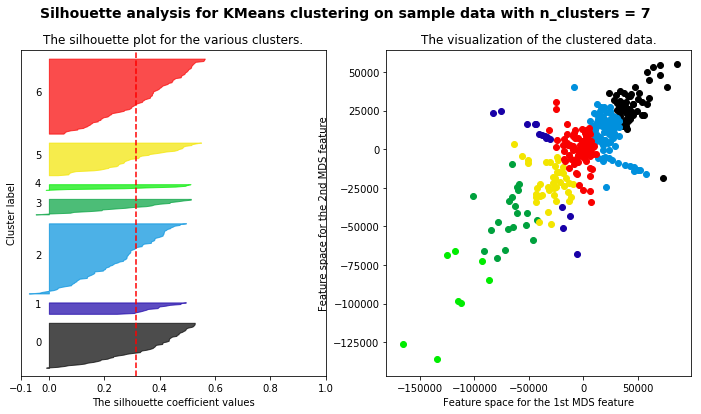

For n_clusters = 8 The average silhouette_score is : 0.328272734613


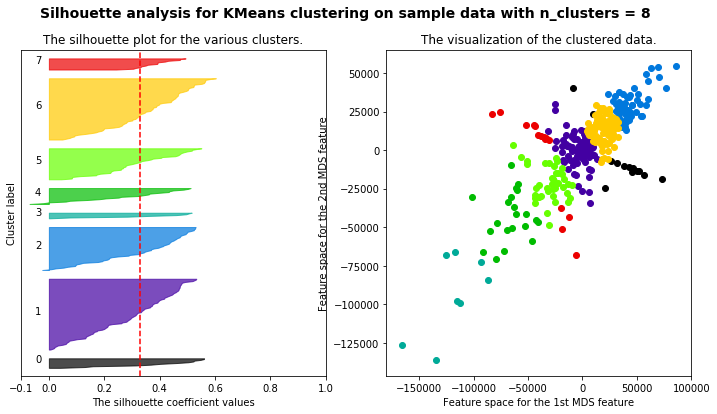

In [265]:
range_n_clusters = [2,3,4,5,6,7,8]
cluster_labelss = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = sbrcluster1.KMeans_fit_predict(cluster)
    cluster_labelss.append(y_pred)
sbrcluster1.silhouette(range_n_clusters, cluster_labelss)

For n_clusters = 2 The average silhouette_score is : 0.555295321396


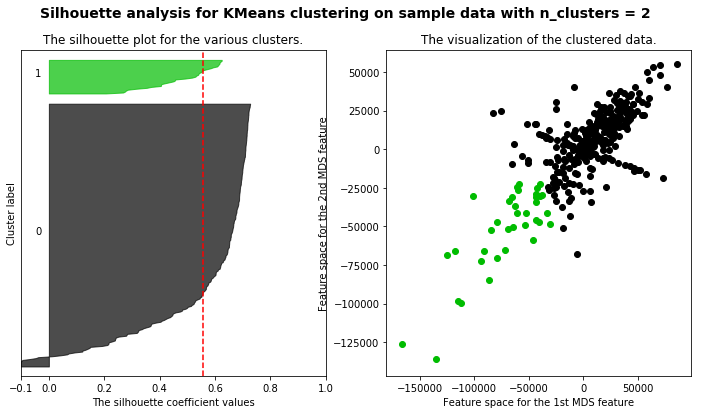

For n_clusters = 3 The average silhouette_score is : 0.395262137069


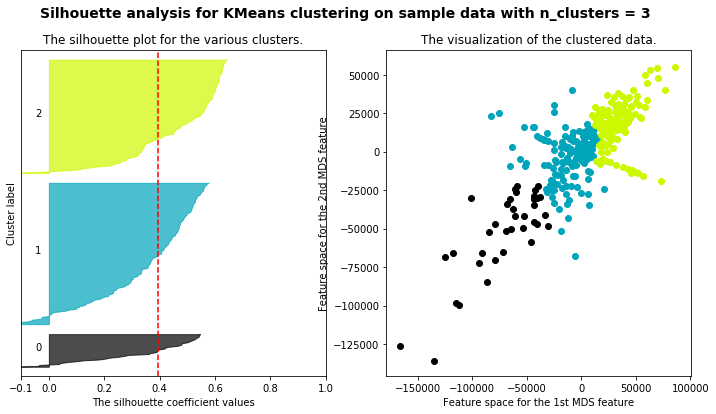

For n_clusters = 4 The average silhouette_score is : 0.383675853305


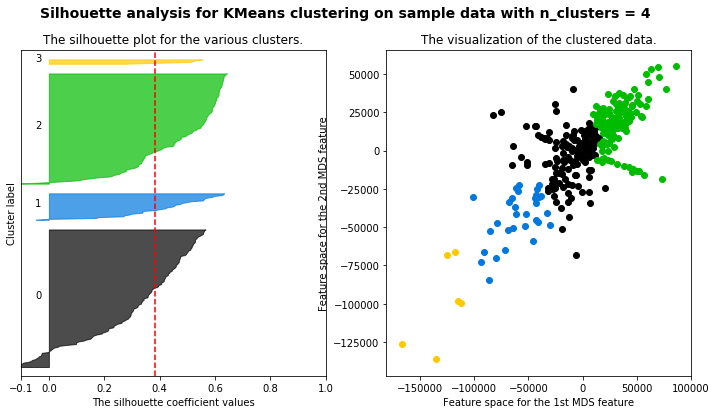

For n_clusters = 5 The average silhouette_score is : 0.378938296879


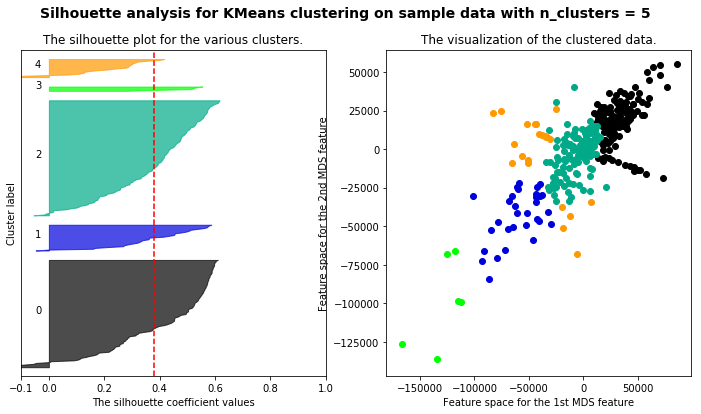

For n_clusters = 6 The average silhouette_score is : 0.292537069748


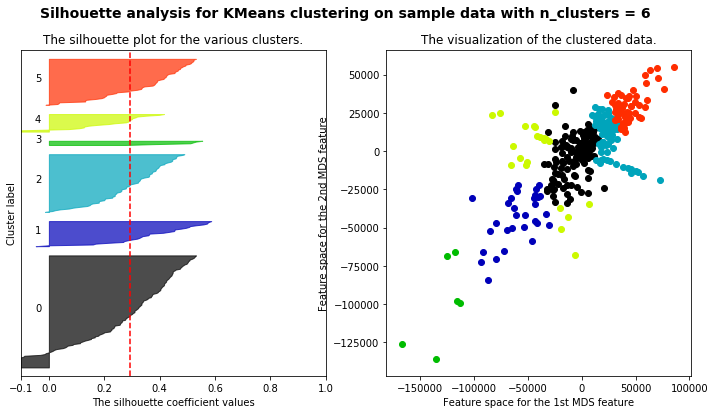

For n_clusters = 7 The average silhouette_score is : 0.295165504049


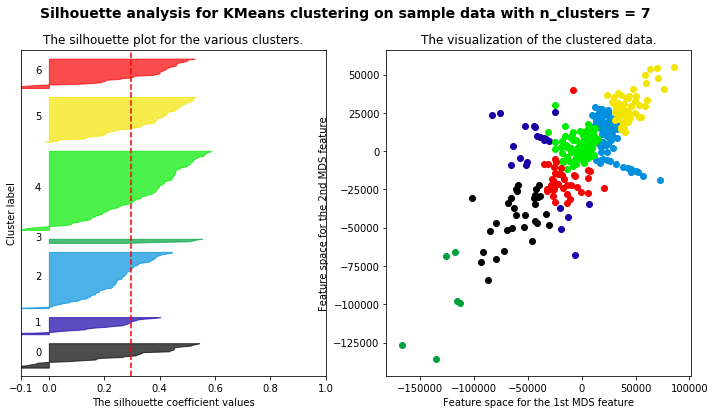

For n_clusters = 8 The average silhouette_score is : 0.292393143821


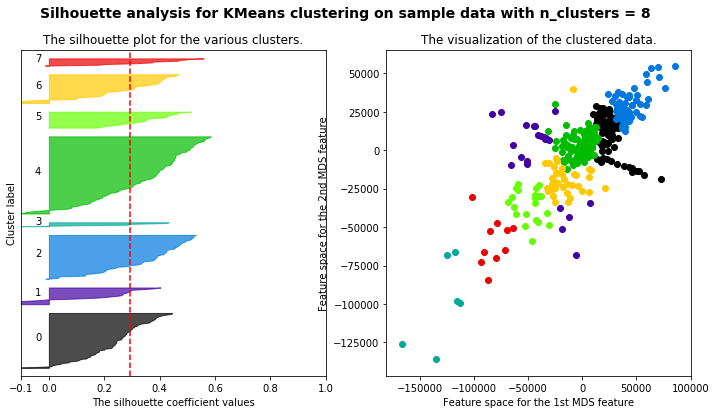

In [279]:
range_n_clusters = [2,3,4,5,6,7,8]
cluster_labelss = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = \
    sbrcluster1.AgglomerativeClustering_fit_predict(cluster, linkage="ward")
    cluster_labelss.append(y_pred)
sbrcluster1.silhouette(range_n_clusters, cluster_labelss)

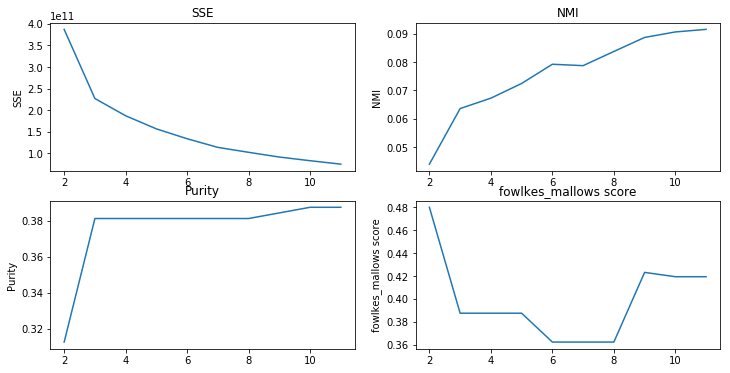

In [285]:
from sklearn.metrics import homogeneity_score
range_n_clusters = [2,3,4,5,6,7,8,9,10,11]
sses = []
nmis = []
purities = []
fms = []
hs = []
for cluster in range_n_clusters:
    categories, y_pred, cluster_centers_, sse, summary = \
    sbrcluster1.AgglomerativeClustering_fit_predict(cluster, linkage="ward")
    sses.append(sse)
    nmi, purity, fowlkes_mallows = sbrcluster1.externalEval(y_pred, sbrcluster.label)
    hs.append(homogeneity_score(y_pred, sbrcluster.label))
    nmis.append(nmi)
    purities.append(purity)
    fms.append(fowlkes_mallows)
visualization().Comparingplot(range_n_clusters, sses, nmis, purities, fms)

In [286]:
hs

[0.090599476653087305,
 0.079842417687349884,
 0.082292125015649809,
 0.081085118498205752,
 0.080201744591586688,
 0.073792163172550926,
 0.077141816972704294,
 0.079860664060182898,
 0.080214667580402466,
 0.080137192972458499]

In [287]:
purities

[0.3125,
 0.38125,
 0.38125,
 0.38125,
 0.38125,
 0.38125,
 0.38125,
 0.384375,
 0.3875,
 0.3875]

Summary: 
KMeans, k=3 
SSE: 221568451812.30569 
Cluster 0: Counter({'Southern': 44, 'Midwestern': 40, 'Western': 28, 'Northeastern': 24, 'California': 6})
Cluster 1: Counter({'Northeastern': 59, 'Midwestern': 29, 'Southern': 29, 'California': 20, 'Western': 13})
Cluster 2: Counter({'Northeastern': 17, 'Southern': 6, 'California': 2, 'Midwestern': 2, 'Western': 1})



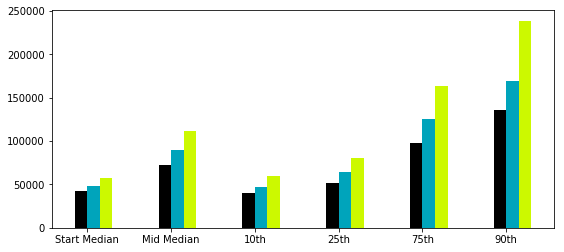

In [283]:
num_cluster = 3
categories, y_pred, cluster_centers_, sse, summary = \
    sbrcluster1.KMeans_fit_predict(num_cluster, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

Summary: 
AgglomerativeClustering, k=3 
SSE: 265292957146.82684 
Cluster 0: Counter({'Northeastern': 60, 'Southern': 25, 'Midwestern': 20, 'California': 15, 'Western': 6})
Cluster 1: Counter({'Southern': 54, 'Midwestern': 51, 'Western': 36, 'Northeastern': 35, 'California': 12})
Cluster 2: Counter({'Northeastern': 5, 'California': 1})



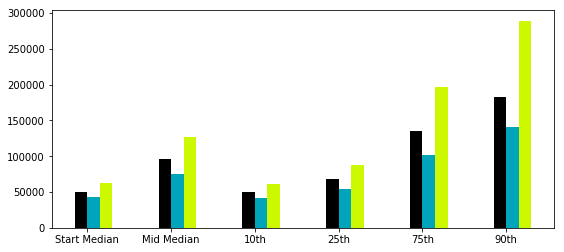

In [284]:
num_cluster = 3
categories, y_pred, cluster_centers_, sse, summary = \
    sbrcluster1.AgglomerativeClustering_fit_predict(num_cluster, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

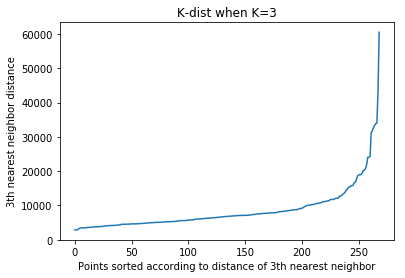

In [215]:
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(sbr.iloc[:, 2:])
distances, indices = nbrs.kneighbors(sbct.iloc[:, 2:])
dist = distances[:, k-1]
dist.sort()
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.plot(np.arange(0, len(dist)), dist)

Summary: 
KMeans, k=4 
SSE: 163518525951.8172 
Cluster 0: Counter({'Midwestern': 35, 'Southern': 34, 'Western': 19, 'Northeastern': 10, 'California': 3})
Cluster 1: Counter({'Northeastern': 33, 'Southern': 16, 'California': 12, 'Midwestern': 10, 'Western': 2})
Cluster 2: Counter({'Northeastern': 12, 'Midwestern': 2, 'California': 1, 'Southern': 1})
Cluster 3: Counter({'Northeastern': 45, 'Southern': 28, 'Midwestern': 24, 'Western': 21, 'California': 12})



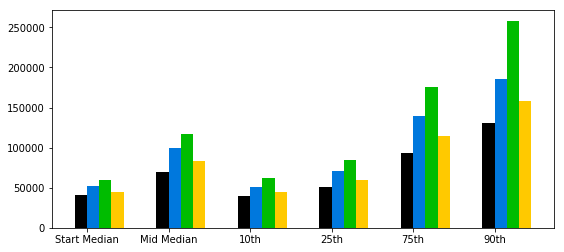

In [188]:
num_cluster = 3
categories, y_pred, cluster_centers_, sse, summary = \
    sbrcluster.KMeans_fit_predict(num_cluster, preproc=0)
visualization().visualizeData(cluster_centers_, summary)

0.05505681037902832
Summary: 
DBSCAN 
SSE: 511245178284.72803 
Cluster -1: Counter({'Northeastern': 12, 'Midwestern': 4, 'California': 3, 'Western': 1})
Cluster 0: Counter({'Northeastern': 81, 'Southern': 77, 'Midwestern': 66, 'Western': 41, 'California': 23})
Cluster 1: Counter({'California': 2, 'Northeastern': 2})
Cluster 2: Counter({'Midwestern': 1, 'Southern': 1, 'Northeastern': 1})
Cluster 3: Counter({'Northeastern': 4, 'Southern': 1})



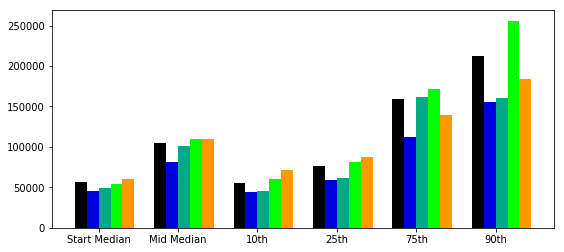

In [282]:
starttime = time.time()
categories, y_pred, cluster_centers_, sse, summary = \
    sbrcluster1.DBSCAN_fit_predict(preproc=0, eps=16000, min_s=3)
endtime = time.time()
print(endtime - starttime)
visualization().visualizeData(cluster_centers_, summary)